2025-04-30 14:27:08.564457: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-04-30 14:27:08.564476: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-04-30 14:27:08.564479: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
I0000 00:00:1746016028.564861   53215 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1746016028.564888   53215 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/10


2025-04-30 14:27:09.189738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-04-30 14:27:09.371191: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


313/313 ━━━━━━━━━━━━━━━━━━━━ 817s 3s/step - accuracy: 0.1685 - loss: 7.5477 - val_accuracy: 0.5534 - val_loss: 2.1306
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 944s 3s/step - accuracy: 0.4278 - loss: 3.8146 - val_accuracy: 0.5982 - val_loss: 1.9145
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 970s 3s/step - accuracy: 0.4907 - loss: 3.0664 - val_accuracy: 0.6187 - val_loss: 1.7507
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 972s 3s/step - accuracy: 0.5248 - loss: 2.6095 - val_accuracy: 0.6162 - val_loss: 1.7198
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 963s 3s/step - accuracy: 0.5436 - loss: 2.3830 - val_accuracy: 0.6160 - val_loss: 1.7223
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 968s 3s/step - accuracy: 0.5542 - loss: 2.2208 - val_accuracy: 0.6190 - val_loss: 1.6851
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 970s 3s/step - accuracy: 0.5611 - loss: 2.1047 - val_accuracy: 0.6283 - val_loss: 1.5919
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 979s 3s/step - accuracy: 0.5635 - loss: 2.0781 - val_accuracy: 0.626

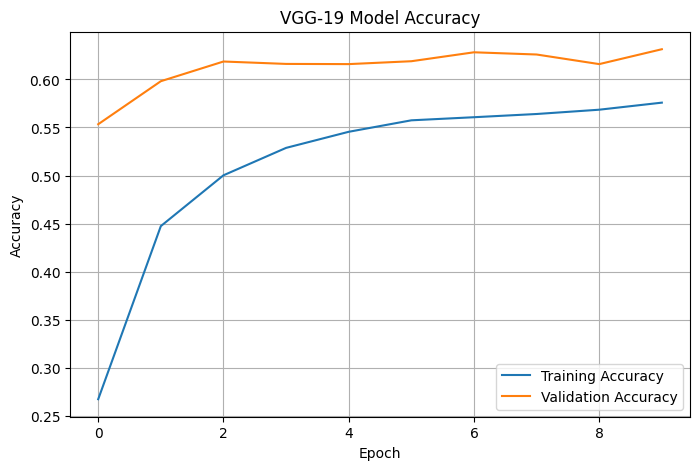

Final Validation Accuracy (VGG19): 63.15%


In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG19
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Load the CIFAR-100 dataset
(ds_train, ds_val), ds_info = tfds.load(
    "cifar100",
    split=["train[:80%]", "train[80%:]"],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

# Get class names
class_names = ds_info.features['label'].names
num_classes = len(class_names)

# Preprocessing for VGG19
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224))  # Resize to VGG19 expected size
    image = tf.keras.applications.vgg19.preprocess_input(image)
    label = tf.one_hot(label, depth=num_classes)
    return image, label

batch_size = 128

train_ds = ds_train.map(preprocess).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = ds_val.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Build the model with VGG-19
base_model = VGG19(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling='avg')
base_model.trainable = False  # Freeze base model

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

# Plot accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('VGG-19 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Show final validation accuracy
final_val_acc = history.history['val_accuracy'][-1] * 100
print(f"Final Validation Accuracy (VGG19): {final_val_acc:.2f}%")
